$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$

$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$
$\newcommand{\der}[2]{\frac{ \mathrm{d} #1 }{ \mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{ \partial #1 }{ \partial #2 }}$

$\newcommand{\R}{\bb{R}}$

# Learning Dynamics

In [1]:
from matplotlib.pyplot import show, subplots

## Robotic Systems

Let $\mathcal{Q} \subseteq \R^n$ be a configuration space. Consider a robotic system governed by:

\begin{equation}
    \mb{D}(\mb{q})\ddot{\mb{q}} + \mb{C}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \mb{G}(\mb{q}) = \mb{B}\mb{u},
\end{equation}

for generalized coordinates $\mb{q} \in \mathcal{Q}$, coordinate rates $\dot{\mb{q}} \in \R^n$, actions $\mb{u} \in \R^m$, inertia matrix function $\mb{D}: \mathcal{Q} \to \bb{S}^n_{++}$ (the space of $n \times n$ positive definite matrices), Coriolis terms $\mb{C}: \mathcal{Q} \times \R^n \to \R^{n \times n}$, potential terms $\mb{G}: \mathcal{Q} \to \R^n$, and static actuation matrix $\mb{B} \in \R^{n \times m}$. Assume $m \leq n$ and $\mb{B}$ is full rank.

### Inverted Pendulum

In [2]:
from numpy import array, identity, linspace

from core.controllers import FBLinController, LQRController

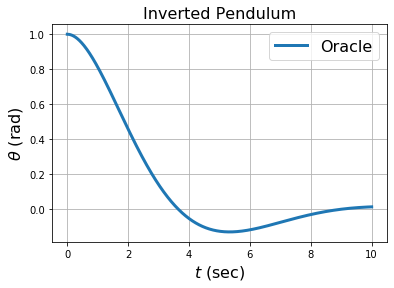

In [3]:
from core.systems import InvertedPendulum

ip = InvertedPendulum(m=0.25, l=0.5)

Q_ip = identity(2)
R_ip = identity(1)
lqr_ip = LQRController.build(ip, Q_ip, R_ip)
fb_lin_ip = FBLinController(ip, lqr_ip)

x_0_ip = array([1, 0])
ts_ip = linspace(0, 10, 1000 + 1)
xs_ip, _ = ip.simulate(x_0_ip, fb_lin_ip, ts_ip)

fig_ip, ax_ip = subplots(figsize=(6, 4))
ax_ip.plot(ts_ip, xs_ip[:, 0], linewidth=3, label='Oracle')
ax_ip.grid()
ax_ip.legend(fontsize=16)
ax_ip.set_title('Inverted Pendulum', fontsize=16)
ax_ip.set_xlabel('$t$ (sec)', fontsize=16)
ax_ip.set_ylabel('$\\theta$ (rad)', fontsize=16)
show()

### Double Inverted Pendulum

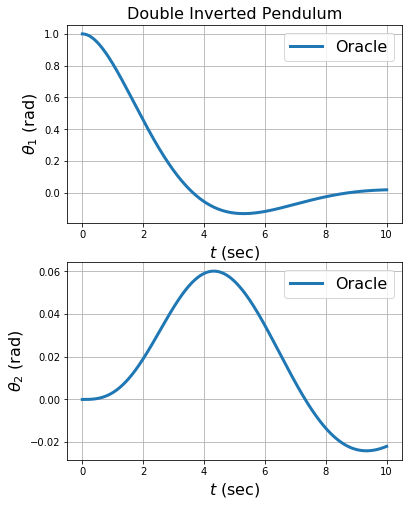

In [4]:
from core.systems import DoubleInvertedPendulum

dip = DoubleInvertedPendulum(m_1=0.25, m_2=0.25, l_1=0.5, l_2=0.5)

Q_dip = identity(4)
R_dip = identity(2)
lqr_dip = LQRController.build(dip, Q_dip, R_dip)
fb_lin_dip = FBLinController(dip, lqr_dip)

x_0_dip = array([1, 0, 0, 0])
ts_dip = linspace(0, 10, 1000 + 1)
xs_dip, _ = dip.simulate(x_0_dip, fb_lin_dip, ts_dip)

fig_dip, (ax_dip_1, ax_dip_2) = subplots(2, figsize=(6, 8))
ax_dip_1.set_title('Double Inverted Pendulum', fontsize=16)

ax_dip_1.plot(ts_dip, xs_dip[:, 0], linewidth=3, label='Oracle')
ax_dip_1.grid()
ax_dip_1.legend(fontsize=16)
ax_dip_1.set_xlabel('$t$ (sec)', fontsize=16)
ax_dip_1.set_ylabel('$\\theta_1$ (rad)', fontsize=16)

ax_dip_2.plot(ts_dip, xs_dip[:, 1], linewidth=3, label='Oracle')
ax_dip_2.grid()
ax_dip_2.legend(fontsize=16)
ax_dip_2.set_xlabel('$t$ (sec)', fontsize=16)
ax_dip_2.set_ylabel('$\\theta_2$ (rad)', fontsize=16)

show()

## Uncertain Robotic Systems

Suppose $\mb{D}$, $\mb{C}$, $\mb{G}$, and $\mb{B}$ are unknown, and instead we have access to corresponding estimates $\hat{\mb{D}}$, $\hat{\mb{C}}$, $\hat{\mb{G}}$, and $\hat{\mb{B}}$ satisfying:

\begin{equation}
    \hat{\mb{D}}(\mb{q})\ddot{\mb{q}} + \hat{\mb{C}}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \hat{\mb{G}}(\mb{q}) = \hat{\mb{B}}\mb{u}.
\end{equation}

Assume that $\hat{\mb{B}}$ is also full rank.

The system dynamics can be in terms of the estimated terms as:

\begin{equation}
    \der{}{t} \begin{bmatrix} \mb{q} \\ \dot{\mb{q}} \end{bmatrix} = \begin{bmatrix} \dot{\mb{q}} \\ -\hat{\mb{D}}(\mb{q})^{-1}(\hat{\mb{C}}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \hat{\mb{G}}(\mb{q})) \end{bmatrix} + \begin{bmatrix} \mb{0}_{n \times m} \\ \hat{\mb{D}}(\mb{q})^{-1}\hat{\mb{B}} \end{bmatrix} \mb{u} + \begin{bmatrix} \mb{0}_n \\ \hat{\mb{D}}(\mb{q})^{-1}(\hat{\mb{C}}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \hat{\mb{G}}(\mb{q}))-\mb{D}(\mb{q})^{-1}(\mb{C}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \mb{G}(\mb{q})) \end{bmatrix} + \begin{bmatrix} \mb{0}_{n \times m} \\ \mb{D}(\mb{q})^{-1}\mb{B} - \hat{\mb{D}}(\mb{q})^{-1}\hat{\mb{B}} \end{bmatrix} \mb{u}
\end{equation}

### Inverted Pendulum

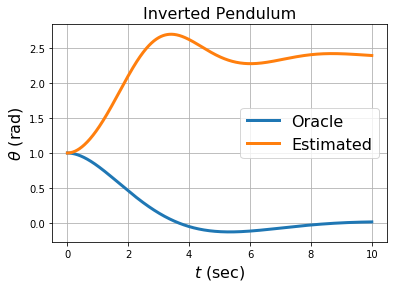

In [5]:
ip_est = InvertedPendulum(m=0.24, l=0.48)

lqr_ip_est = LQRController.build(ip_est, Q_ip, R_ip)
fb_lin_ip_est = FBLinController(ip_est, lqr_ip_est)

xs_ip, us_ip = ip.simulate(x_0_ip, fb_lin_ip_est, ts_ip)

ax_ip.plot(ts_ip, xs_ip[:, 0], linewidth=3, label='Estimated')
ax_ip.legend(fontsize=16)
fig_ip

### Double Inverted Pendulum

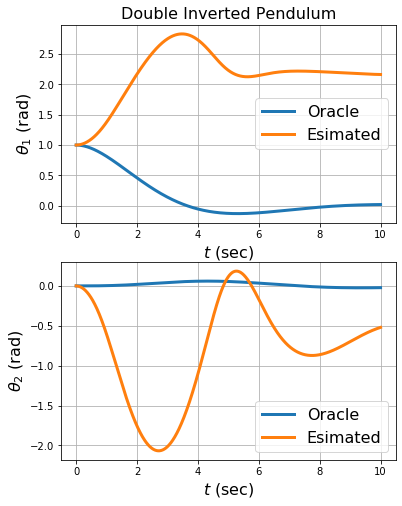

In [6]:
dip_est = DoubleInvertedPendulum(m_1=0.24, m_2=0.24, l_1=0.48, l_2=0.48)

lqr_dip_est = LQRController.build(dip_est, Q_dip, R_dip)
fb_lin_dip_est = FBLinController(dip_est, lqr_dip_est)

xs_dip, us_dip = dip.simulate(x_0_dip, fb_lin_dip_est, ts_dip)

ax_dip_1.plot(ts_dip, xs_dip[:, 0], linewidth=3, label='Esimated')
ax_dip_1.legend(fontsize=16)

ax_dip_2.plot(ts_dip, xs_dip[:, 1], linewidth=3, label='Esimated')
ax_dip_2.legend(fontsize=16)

fig_dip

## Learning Dynamics

In [7]:
from tensorflow.logging import ERROR, set_verbosity
set_verbosity(ERROR)

### Inverted Pendulum

In [8]:
from core.dynamics import LearnedFBLinDynamics
from core.learning.keras import KerasResidualAffineModel

Using TensorFlow backend.


In [9]:
d_drift_in_ip = 3
d_act_in_ip = 3
d_hidden_ip = 20
d_out_ip = 1

res_model_ip = KerasResidualAffineModel(d_drift_in_ip, d_act_in_ip, d_hidden_ip, 1, d_out_ip)
ip_learned = LearnedFBLinDynamics(ip_est, res_model_ip)
data = ip_learned.process_episode(xs_ip, us_ip, ts_ip)
ip_learned.fit(data, num_epochs=10, validation_split=0.1)

Train on 898 samples, validate on 100 samples
Epoch 1/10
898/898 [==============================] - 1s 2ms/step - loss: 0.2794 - val_loss: 0.1563
Epoch 2/10
898/898 [==============================] - 1s 1ms/step - loss: 0.0626 - val_loss: 0.0301
Epoch 3/10
898/898 [==============================] - 1s 2ms/step - loss: 0.0385 - val_loss: 0.0207
Epoch 4/10
898/898 [==============================] - 1s 2ms/step - loss: 0.0358 - val_loss: 0.0482
Epoch 5/10
898/898 [==============================] - 1s 1ms/step - loss: 0.0352 - val_loss: 0.0293
Epoch 6/10
898/898 [==============================] - 1s 1ms/step - loss: 0.0339 - val_loss: 0.0289
Epoch 7/10
898/898 [==============================] - 1s 1ms/step - loss: 0.0343 - val_loss: 0.0443
Epoch 8/10
898/898 [==============================] - 1s 1ms/step - loss: 0.0331 - val_loss: 0.0380
Epoch 9/10
898/898 [==============================] - 1s 1ms/step - loss: 0.0325 - val_loss: 0.0279
Epoch 10/10
898/898 [==============================] -

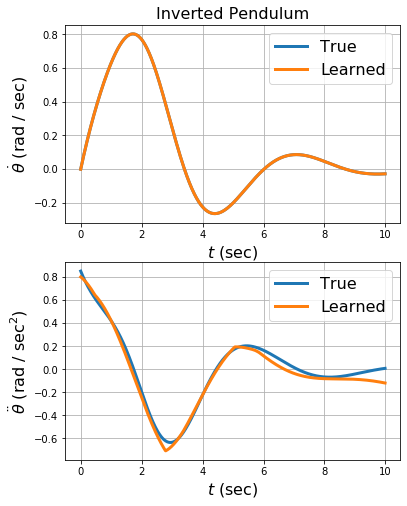

In [10]:
x_dots = array([ip.eval_dot(x, u, t) for x, u, t in zip(xs_ip, us_ip, ts_ip)])

_, (ax_ip_1, ax_ip_2) = subplots(2, figsize=(6, 8))
ax_ip_1.set_title('Inverted Pendulum', fontsize=16)

ax_ip_1.plot(ts_ip[:-1], x_dots[:, 0], linewidth=3, label='True')
ax_ip_1.grid()
ax_ip_1.set_xlabel('$t$ (sec)', fontsize=16)
ax_ip_1.set_ylabel('$\\dot{\\theta}$ (rad / sec)', fontsize=16)

ax_ip_2.plot(ts_ip[:-1], x_dots[:, 1], linewidth=3, label='True')
ax_ip_2.grid()
ax_ip_2.set_xlabel('$t$ (sec)', fontsize=16)
ax_ip_2.set_ylabel('$\\ddot{\\theta}$ (rad / sec$^2$)', fontsize=16)

x_dots = array([ip_learned.eval_dot(x, u, t) for x, u, t in zip(xs_ip, us_ip, ts_ip)])

ax_ip_1.plot(ts_ip[:-1], x_dots[:, 0], linewidth=3, label='Learned')
ax_ip_1.legend(fontsize=16)

ax_ip_2.plot(ts_ip[:-1], x_dots[:, 1], linewidth=3, label='Learned')
ax_ip_2.legend(fontsize=16)

show()

### Double Inverted Pendulum

In [11]:
d_drift_in_dip = 5
d_act_in_dip = 5
d_hidden_dip = 40
d_out_dip = 2

res_model_dip = KerasResidualAffineModel(d_drift_in_dip, d_act_in_dip, d_hidden_dip, 2, d_out_dip)
dip_learned = LearnedFBLinDynamics(dip_est, res_model_dip)
data = dip_learned.process_episode(xs_dip, us_dip, ts_dip)
dip_learned.fit(data, num_epochs=10, validation_split=0.1)

Train on 898 samples, validate on 100 samples
Epoch 1/10
898/898 [==============================] - 1s 2ms/step - loss: 0.8036 - val_loss: 0.7987
Epoch 2/10
898/898 [==============================] - 1s 1ms/step - loss: 0.3102 - val_loss: 0.2532
Epoch 3/10
898/898 [==============================] - 1s 1ms/step - loss: 0.1878 - val_loss: 0.1682
Epoch 4/10
898/898 [==============================] - 1s 1ms/step - loss: 0.1601 - val_loss: 0.1361
Epoch 5/10
898/898 [==============================] - 1s 1ms/step - loss: 0.1364 - val_loss: 0.1170
Epoch 6/10
898/898 [==============================] - 1s 1ms/step - loss: 0.1188 - val_loss: 0.1140
Epoch 7/10
898/898 [==============================] - 1s 1ms/step - loss: 0.1089 - val_loss: 0.1128
Epoch 8/10
898/898 [==============================] - 1s 1ms/step - loss: 0.1025 - val_loss: 0.0734
Epoch 9/10
898/898 [==============================] - 1s 1ms/step - loss: 0.0946 - val_loss: 0.0686
Epoch 10/10
898/898 [==============================] -

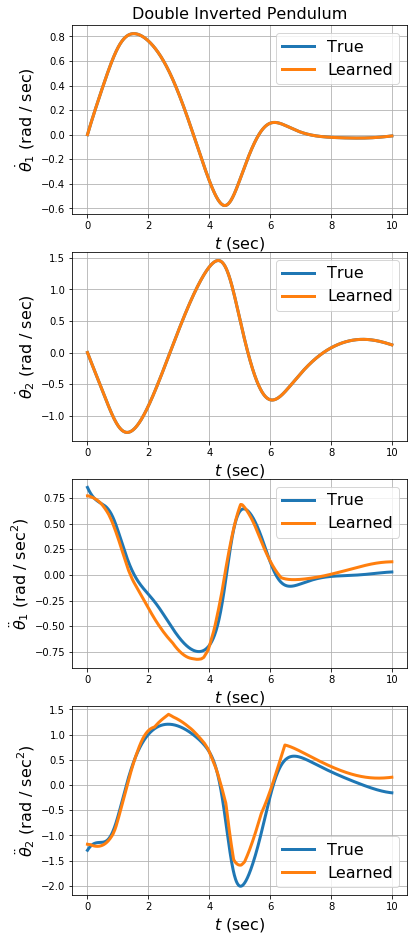

In [12]:
x_dots = array([dip.eval_dot(x, u, t) for x, u, t in zip(xs_dip, us_dip, ts_dip)])

_, axs_dip = subplots(4, figsize=(6, 16))
axs_dip[0].set_title('Double Inverted Pendulum', fontsize=16)
ylabels = ['$\\dot{\\theta}_1$ (rad / sec)', '$\\dot{\\theta}_2$ (rad / sec)', '$\\ddot{\\theta}_1$ (rad / sec$^2$)', '$\\ddot{\\theta}_2$ (rad / sec$^2$)']

for ax, data, ylabel in zip(axs_dip, x_dots.T, ylabels):
    ax.plot(ts_dip[:-1], data, linewidth=3, label='True')
    ax.grid()
    ax.set_xlabel('$t$ (sec)', fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    
x_dots = array([dip_learned.eval_dot(x, u, t) for x, u, t in zip(xs_dip, us_dip, ts_dip)])

for ax, data in zip(axs_dip, x_dots.T):
    ax.plot(ts_dip[:-1], data, linewidth=3, label='Learned')
    ax.legend(fontsize=16)
    
show()

## Overfitting

### Inverted Pendulum

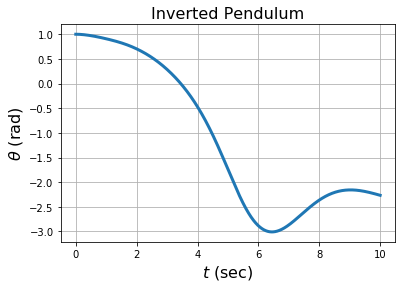

In [13]:
lqr_learned_ip = LQRController.build(ip_learned, Q_ip, R_ip)
fb_lin_learned_ip = FBLinController(ip_learned, lqr_learned_ip)

xs, _ = ip.simulate(x_0_ip, fb_lin_learned_ip, ts_ip)

_, ax = subplots(figsize=(6, 4))
ax.plot(ts_ip, xs[:, 0], linewidth=3)
ax.grid()
ax.set_title('Inverted Pendulum', fontsize=16)
ax.set_xlabel('$t$ (sec)', fontsize=16)
ax.set_ylabel('$\\theta$ (rad)', fontsize=16)

show()

### Double Inverted Pendulum

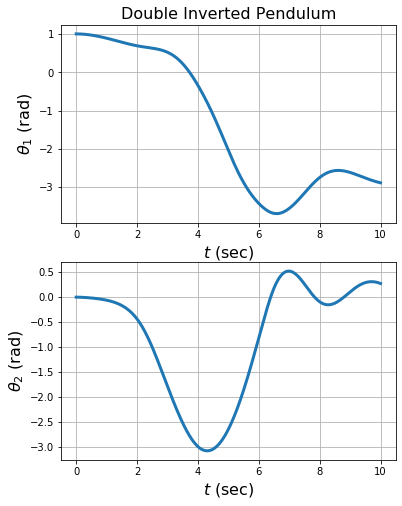

In [14]:
lqr_learned_dip = LQRController.build(dip_learned, Q_dip, R_dip)
fb_lin_learned_dip = FBLinController(dip_learned, lqr_learned_dip)

xs, _ = dip.simulate(x_0_dip, fb_lin_learned_dip, ts_dip)

_, (ax_1, ax_2) = subplots(2, figsize=(6, 8))
ax_1.set_title('Double Inverted Pendulum', fontsize=16)

ax_1.plot(ts_dip, xs[:, 0], linewidth=3)
ax_1.grid()
ax_1.set_xlabel('$t$ (sec)', fontsize=16)
ax_1.set_ylabel('$\\theta_1$ (rad)', fontsize=16)

ax_2.plot(ts_dip, xs[:, 1], linewidth=3)
ax_2.grid()
ax_2.set_xlabel('$t$ (sec)', fontsize=16)
ax_2.set_ylabel('$\\theta_2$ (rad)', fontsize=16)

show()